## Optimizing synthesizer parameters using gradient approximation

This notebook looks at using gradient approximationt to estimate gradients over a
black-box synthesizer. It uses simultaneous perturbation stochastic approximation
(SPSA) to estimate the gradients for synthesizer parameters. This technique was
used by Marco A. Martínez Ramírez et al. in their work on [Differentiable Signal
Processing With Black-Box Audio Effects](https://arxiv.org/abs/2105.04752).

The goal here is to try to implement that so that we can use a
[torchsynth](https://github.com/torchsynth/torchsynth) synthesizer in deep
learning training.

In this notebook I just experiment with optimizing a few parameters in a simple
synthesizer to match a target sound using gradient descent.

**Note:** In google colab use a GPU runtime. For some reason the optimization doesn't work otherwise

In [1]:
# For google collab
! rm -rf torchsynth-grad-approx
! git clone https://github.com/jorshi/torchsynth-grad-approx.git
%cd torchsynth-grad-approx/
! pip install -r requirements.txt

Cloning into 'torchsynth-grad-approx'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 73 (delta 32), reused 68 (delta 31), pack-reused 0
Unpacking objects: 100% (73/73), 1.97 MiB | 3.41 MiB/s, done.
/home/jshier/development/nash/torchsynth-grad-approx


In [2]:
import auraloss
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchsynth.config import SynthConfig
from tqdm import tqdm
import IPython.display as ipd

from module import TorchSynthSPSA, TorchSynthModule
from synth import SimpleSynth

%load_ext autoreload
%autoreload 2

In [3]:
# Run on a GPU if available
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### The Synthesizer
The synth that we'll use for this is a super simple one. It has a single
saw/square oscillator that recieves a midi pitch, the resulting audio is
then sent to an amplitude gate (VCA) that is controlled by an
attack-decay-sustain-release (ADSR) envelope.

The simple synth is built with torchsynth, which is a GPU-enabled synthesizer
framework built in PyTorch. It renders sounds in batches on a GPU so multiple
synth patches can be created at once.

In [4]:
# Configure Synth
BATCH_SIZE = 8
SR = 44100
DURATION = 1.0

synth_config = SynthConfig(
    batch_size=BATCH_SIZE,
    buffer_size_seconds=DURATION,
    sample_rate=SR,
    reproducible=False,
)
synth = SimpleSynth(synth_config)
synth = synth.to(device)

Render and listen to 8 random patches at once

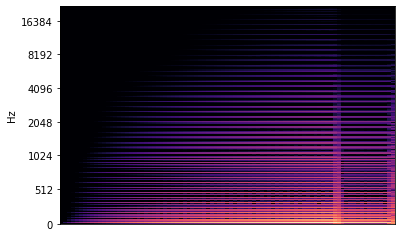

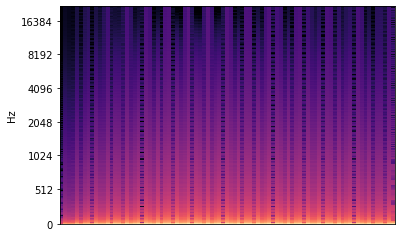

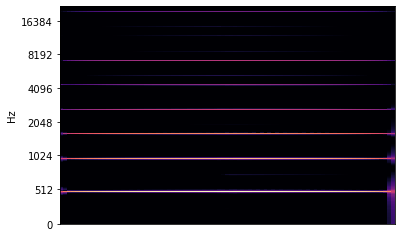

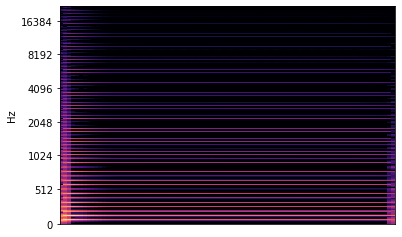

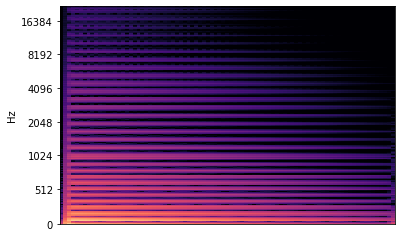

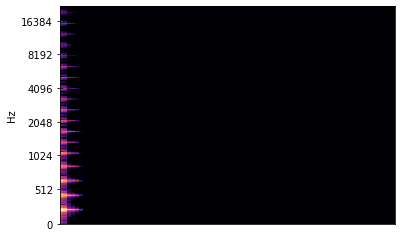

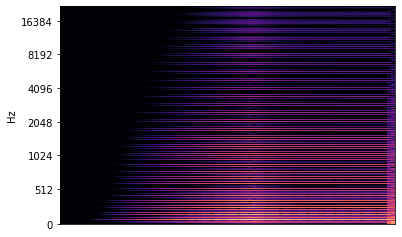

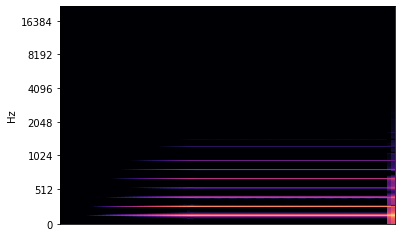

In [5]:
synth.randomize()
audio, parameters, test_train = synth()

for a in audio:
    # plot Mel-spectrogram
    plt.figure()
    D1 = librosa.amplitude_to_db(
        np.abs(librosa.stft(a.detach().cpu().numpy())), ref=np.max
    )
    librosa.display.specshow(D1, sr=SR, y_axis="mel")
    plt.show()

    # plot audio
    ipd.display(ipd.Audio(a.cpu().numpy(), rate=SR))

These are all the parameters that can control this synthesizer

In [6]:
synth.get_parameters()

OrderedDict([(('adsr', 'attack'),
              ModuleParameter(name=attack, value=tensor([0.6441, 0.4295, 0.5091, 0.0756, 0.8653, 0.0060, 0.5370, 0.4407],
                     device='cuda:0'))),
             (('adsr', 'decay'),
              ModuleParameter(name=decay, value=tensor([0.0193, 0.8473, 0.4846, 0.3382, 0.3114, 0.2409, 0.3664, 0.2298],
                     device='cuda:0'))),
             (('adsr', 'sustain'),
              ModuleParameter(name=sustain, value=tensor([0.4914, 0.6619, 0.0515, 0.0848, 0.0651, 0.0512, 0.4075, 0.9326],
                     device='cuda:0'))),
             (('adsr', 'release'),
              ModuleParameter(name=release, value=tensor([0.8946, 0.4230, 0.9830, 0.7358, 0.6650, 0.0822, 0.1213, 0.7847],
                     device='cuda:0'))),
             (('adsr', 'alpha'),
              ModuleParameter(name=alpha, value=tensor([0.3108, 0.0607, 0.0916, 0.8299, 0.9500, 0.9622, 0.7290, 0.7926],
                     device='cuda:0'))),
             ((

### Optimize Three Parameters

So torchsynth is built in PyTorch, but it isn't differentiable (yet :) ).
So for this hack I am going to experiment with SPSA and see if I can perform
sound matching.

To keep things simple I'm just focusing on the attack, decay, and the shape of
the osc (amount of saw vs. square). The rest of the parameters get frozen at
some setting.

In [7]:
# Just focus on a single sound (batch size of 1)
BATCH_SIZE = 1
synth_config = SynthConfig(
    batch_size=BATCH_SIZE,
    buffer_size_seconds=DURATION,
    sample_rate=SR,
    reproducible=False,
)
synth = SimpleSynth(synth_config)
synth = synth.to(device)

In [8]:
synth.unfreeze_all_parameters()

# The commented parameters will be open for optimization
synth.set_parameters(
    {
        ("keyboard", "midi_f0"): torch.tensor([36] * BATCH_SIZE),
        ("keyboard", "duration"): torch.tensor([0.9] * BATCH_SIZE),
        # ("adsr", "attack"): torch.tensor([0.0] * BATCH_SIZE),
        # ("adsr", "decay"): torch.tensor([0.5] * BATCH_SIZE),
        ("adsr", "sustain"): torch.tensor([0.0] * BATCH_SIZE),
        ("adsr", "release"): torch.tensor([0.1] * BATCH_SIZE),
        ("adsr", "alpha"): torch.tensor([5.0] * BATCH_SIZE),
        ("vco", "tuning"): torch.tensor([0.0] * BATCH_SIZE),
        ("vco", "initial_phase"): torch.tensor([0.0] * BATCH_SIZE),
        ("vco", "mod_depth"): torch.tensor([0.0] * BATCH_SIZE),
        # ("vco", "shape"): torch.tensor([0.0] * BATCH_SIZE),
    },
    freeze=True,
)
synth = synth.to(device)

#### Target Sound
This will be the target sound that we'll try to sound match.

In [9]:
synth.randomize(seed=43)  # Change this seed to test other targets
target_audio, _, _ = synth()
ipd.Audio(target_audio[0].cpu().numpy(), rate=SR)

#### SPSA Module
TorchSynthModule is a PyTorch module that utilizes SPSA to estimate gradients
for all the un-frozen parameters in a torchsynth synth. The parameters are randomized
upon initialization. This is a starting point for optimization.

In [10]:
# Initialize a TorchSynthModule for optimizing
torch.manual_seed(4)  # Change this seed to test other starting points
synth_optim = TorchSynthModule(synth).to(device)

audio = synth_optim()

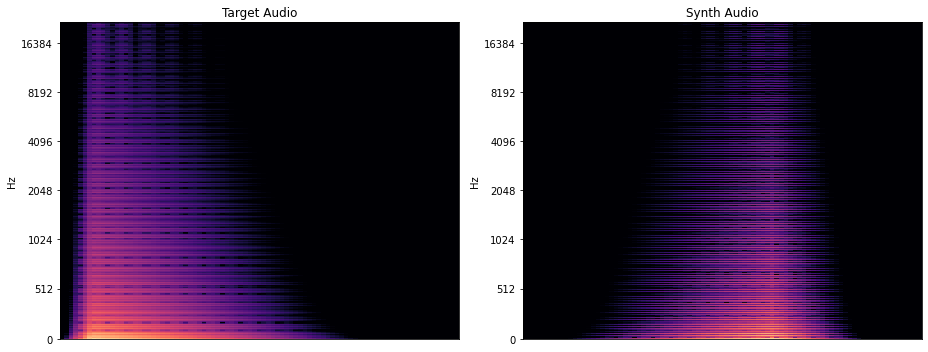

Target


Synth


In [11]:
def plot_spectrograms(target, audio, ax1, ax2):
    D1 = librosa.amplitude_to_db(
        np.abs(librosa.stft(target[0].detach().cpu().numpy())), ref=np.max
    )
    librosa.display.specshow(D1, sr=SR, y_axis="mel", ax=ax1)
    ax1.set_title("Target Audio")

    D2 = librosa.amplitude_to_db(
        np.abs(librosa.stft(audio[0].detach().cpu().numpy())), ref=np.max
    )
    librosa.display.specshow(D2, sr=SR, y_axis="mel", ax=ax2)
    ax2.set_title("Synth Audio")

    plt.tight_layout()


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
plot_spectrograms(target_audio, audio, ax1, ax2)
plt.show()

print("Target")
ipd.display(ipd.Audio(target_audio[0].cpu().numpy(), rate=SR))

print("Synth")
ipd.display(ipd.Audio(audio[0].detach().cpu().numpy(), rate=SR))

### Loss Function

The loss function used during optimization is multi-resolution STFT loss from
[auraloss](https://github.com/csteinmetz1/auraloss)

In [12]:
# Loss
mrstft = auraloss.freq.MultiResolutionSTFTLoss()

error = mrstft(target_audio[:, None, :], audio[:, None, :])

print("Initial error between the target audio and synth audio:", error)

Initial error between the target audio and synth audio: tensor(4.2697, device='cuda:0', grad_fn=<AliasBackward>)


### Optimization
Now use gradient descent to optimize the parameters of the synth to match the target
sound. At each iteration the gradient for the parameters is estimated using SPSA.
This works by randomly adjusting the parameters +/- by a small amount and using that
to derive an approximation for the gradient.

In [13]:
optimizer = torch.optim.Adam((list(synth_optim.parameters())[0],), lr=0.005)
error_log = []
pbar = tqdm(range(3000), desc="Iter 0")
for i in pbar:
    optimizer.zero_grad()
    audio = synth_optim()

    error = mrstft(target_audio[:, None, :], audio[:, None, :])
    error_log.append(error.detach().cpu().float())

    # If the error gets this low that's great - stop there and party
    if error < 0.05:
        break

    pbar.set_description(f"Iter {i}: Error: {error}")

    error.backward()
    optimizer.step()

Iter 554: Error: 0.05090954154729843:  18%|█▊        | 555/3000 [00:10<00:44, 55.05it/s] 


Text(0.5, 1.0, 'Multi-resolution STFT Error over iterations')

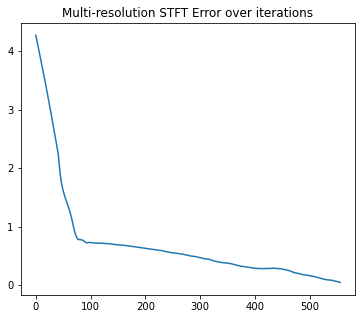

In [14]:
plt.figure(figsize=(6, 5))
plt.plot(error_log)
plt.title("Multi-resolution STFT Error over iterations")

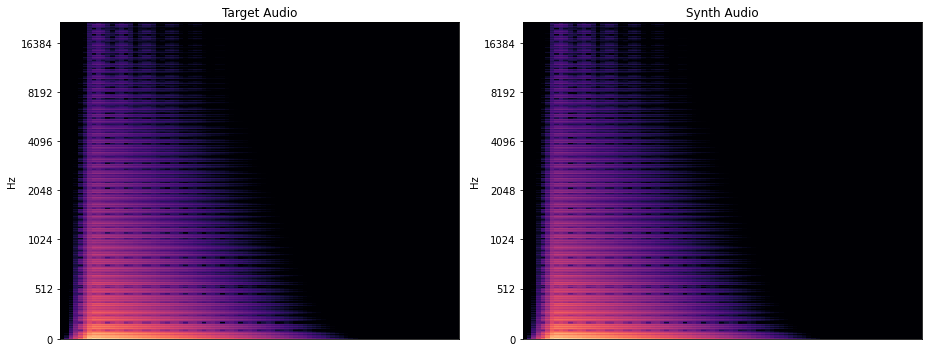

Target


Synth


In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
plot_spectrograms(target_audio, audio, ax1, ax2)
plt.show()

print("Target")
ipd.display(ipd.Audio(target_audio[0].cpu().numpy(), rate=SR))

print("Synth")
ipd.display(ipd.Audio(audio[0].detach().cpu().numpy(), rate=SR))